# Pre-eQTL analysis control samples data wrangling

__Author:__ Bryan Quach  
__Date:__ April 26, 2017

## Objective: Create phenotype and design matrices for eQTL analysis

The eQTL software requires as input a [design matrix](https://en.wikipedia.org/wiki/Design_matrix) and a phenotype matrix. This document outlines the steps we take in generating the matrices for downstream tissue-specific eQTL analyses in control samples.

### Estimated Analysis Time: <1 days

## Software

* [DESeq2](http://www.bioconductor.org/packages/release/bioc/html/DESeq2.html)

## Analysis Outline

* Creating tissue-specific phenotype matrices
* Creating tissue-specific covariate matrices

## Phenotype matrix construction

The phenotype we have is gene expression values in liver, lung, and kidney tissue. We start with RSEM derived TPM matrices and apply median ratio normalization using DESeq2. This decision is based off of discussions with Dr. Michael Love about making samples comparable across samples while also including within-sample normalization. This two-step normalization was applied by Michael in a [recent Nature paper](http://www.nature.com/nbt/journal/v34/n12/full/nbt.3682.html).

In previous notebooks, we applied both between-sample normalization and within-sample normalization separately to generate to variants of eQTL phenotype matrices. This notebook combines the two to allow for comparable scales across both samples and genes.

In [2]:
library(DESeq2)

#Load TPM data
load("data/tpm_data.original.Rdata")
all.cts <- cbind(txi.rsem.htsf$abundance, txi.rsem.tamu$abundance, txi.rsem.merged$abundance)

#Reformat sample names
sample.names <- sapply(strsplit(x=colnames(all.cts), split='_'), function(x){paste0(x[1:3],collapse="_")})
colnames(all.cts) <- sample.names

#Separate samples by tissue type and filter out non-controls
filtered.cts <- all.cts[,grepl(colnames(all.cts), pattern="_0ppm_", ignore.case=T)]
kidney.cts <- filtered.cts[,grepl(colnames(filtered.cts), pattern="kidney", ignore.case=T)]
liver.cts <- filtered.cts[,grepl(colnames(filtered.cts), pattern="liver", ignore.case=T)]
lung.cts <- filtered.cts[,grepl(colnames(filtered.cts), pattern="lung", ignore.case=T)]

#Apply median ratio normalization per tissue
lung.size.factors <- estimateSizeFactorsForMatrix(lung.cts)
liver.size.factors <- estimateSizeFactorsForMatrix(liver.cts)
kidney.size.factors <- estimateSizeFactorsForMatrix(kidney.cts)
lung.norm.cts <- sweep(lung.cts, 2, lung.size.factors, "/")
liver.norm.cts <- sweep(liver.cts, 2, liver.size.factors, "/")
kidney.norm.cts <- sweep(kidney.cts, 2, kidney.size.factors, "/")

Loading required package: S4Vectors
Loading required package: stats4
Loading required package: BiocGenerics
Loading required package: parallel

Attaching package: ‘BiocGenerics’

The following objects are masked from ‘package:parallel’:

    clusterApply, clusterApplyLB, clusterCall, clusterEvalQ,
    clusterExport, clusterMap, parApply, parCapply, parLapply,
    parLapplyLB, parRapply, parSapply, parSapplyLB

The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs

The following objects are masked from ‘package:base’:

    anyDuplicated, append, as.data.frame, cbind, colMeans, colnames,
    colSums, do.call, duplicated, eval, evalq, Filter, Find, get, grep,
    grepl, intersect, is.unsorted, lapply, lengths, Map, mapply, match,
    mget, order, paste, pmax, pmax.int, pmin, pmin.int, Position, rank,
    rbind, Reduce, rowMeans, rownames, rowSums, sapply, setdiff, sort,
    table, tapply, union, unique, unsplit, which, which.max, which.min


Attaching packag

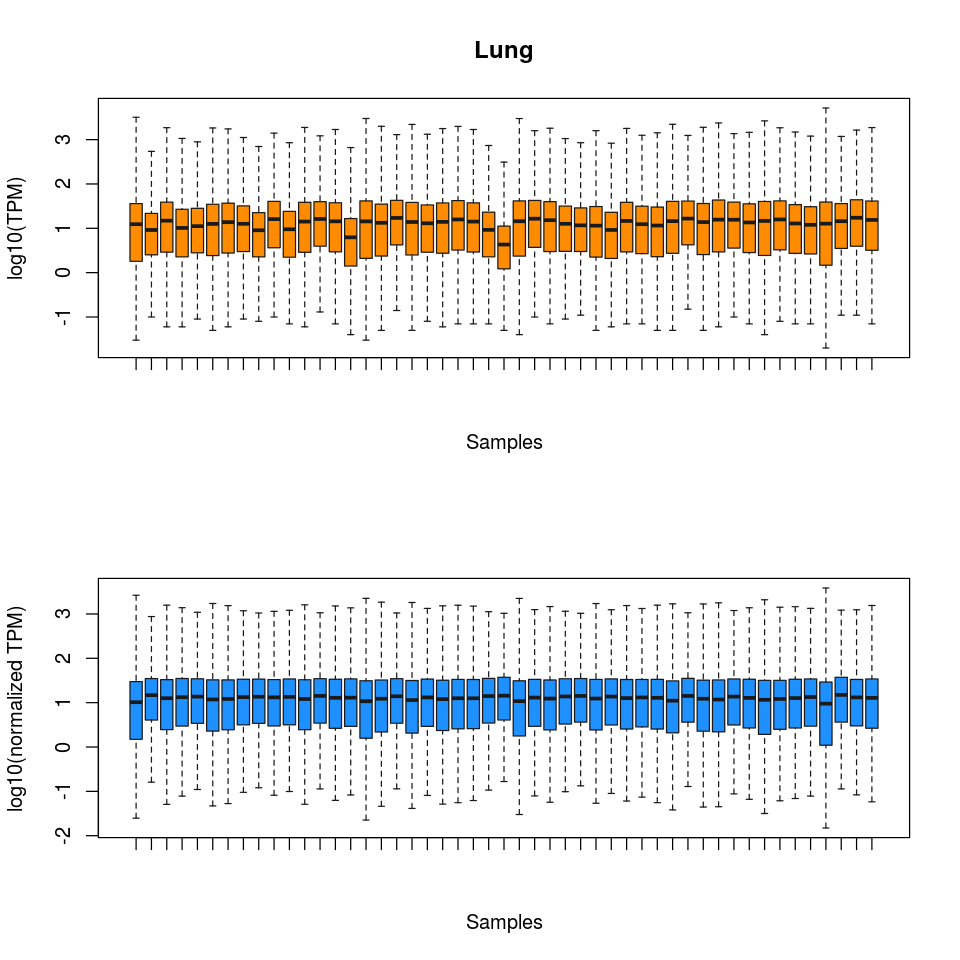

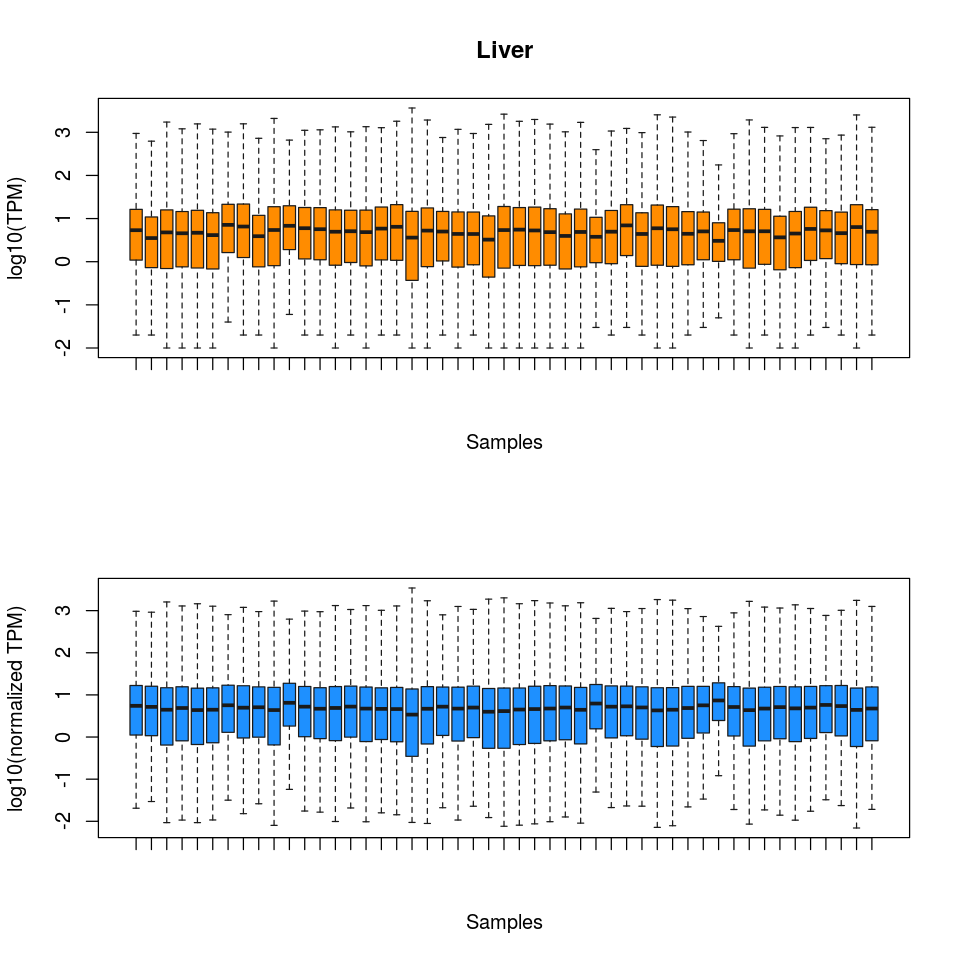

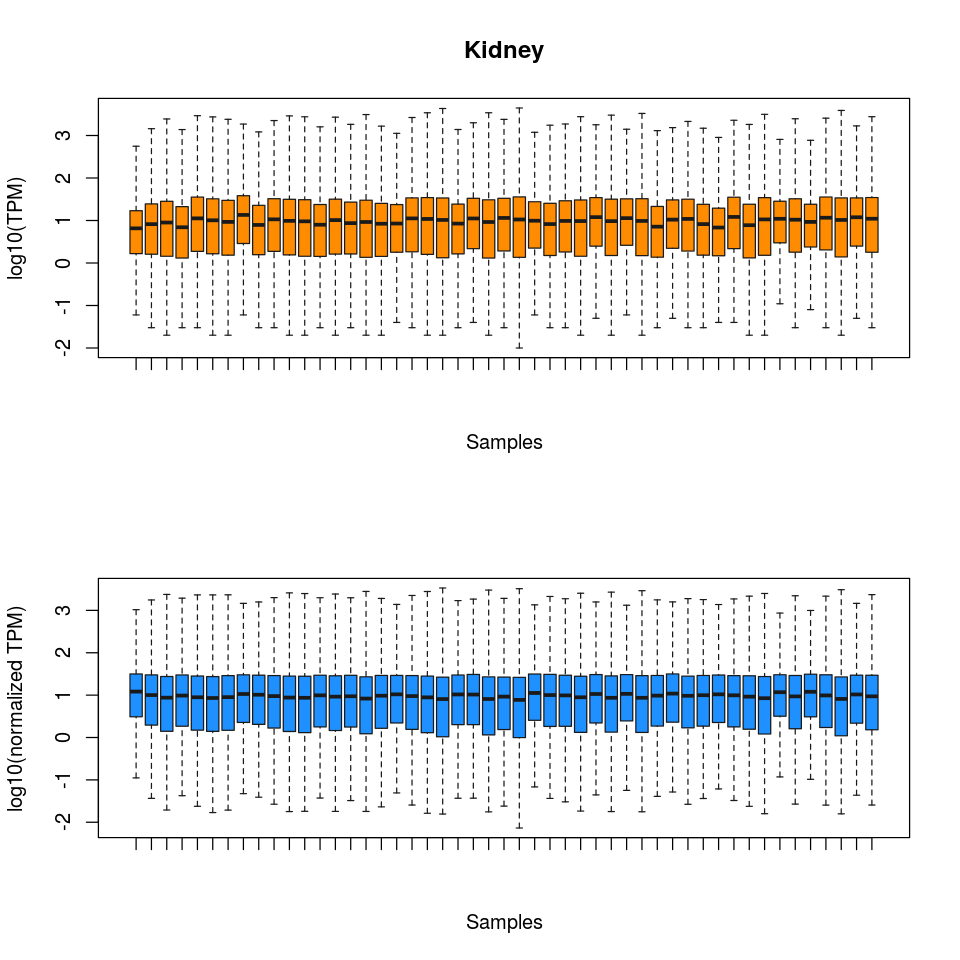

In [2]:
#Visualize before and after normalization
options(repr.plot.width=8, repr.plot.height=8)

#Lung
log.lung.cts <- log10(lung.cts)
log.lung.norm.cts <- log10(lung.norm.cts)
is.na(log.lung.cts) <- sapply(log.lung.cts, is.infinite)
is.na(log.lung.norm.cts) <- sapply(log.lung.norm.cts, is.infinite)
par(mfrow=c(2,1))
boxplot(log.lung.cts, names=NA, outline=F, 
        col="darkorange", border="gray10", 
        ylab="log10(TPM)", xlab="Samples", main="Lung")
boxplot(log.lung.norm.cts, names=NA, outline=F, 
        col="dodgerblue", border="gray10", 
        ylab="log10(normalized TPM)", xlab="Samples")

#Liver
log.liver.cts <- log10(liver.cts)
log.liver.norm.cts <- log10(liver.norm.cts)
is.na(log.liver.cts) <- sapply(log.liver.cts, is.infinite)
is.na(log.liver.norm.cts) <- sapply(log.liver.norm.cts, is.infinite)
par(mfrow=c(2,1))
boxplot(log.liver.cts, names=NA, outline=F, 
        col="darkorange", border="gray10", 
        ylab="log10(TPM)", xlab="Samples", main="Liver")
boxplot(log.liver.norm.cts, names=NA, outline=F, 
        col="dodgerblue", border="gray10", 
        ylab="log10(normalized TPM)", xlab="Samples")

#Kidney
log.kidney.cts <- log10(kidney.cts)
log.kidney.norm.cts <- log10(kidney.norm.cts)
is.na(log.kidney.cts) <- sapply(log.kidney.cts, is.infinite)
is.na(log.kidney.norm.cts) <- sapply(log.kidney.norm.cts, is.infinite)
par(mfrow=c(2,1))
boxplot(log.kidney.cts, names=NA, outline=F, 
        col="darkorange", border="gray10", 
        ylab="log10(TPM)", xlab="Samples", main="Kidney")
boxplot(log.kidney.norm.cts, names=NA, outline=F, 
        col="dodgerblue", border="gray10", 
        ylab="log10(normalized TPM)", xlab="Samples")

Based on the boxplots above, the normalizations appear to have appropriately scaled the TPM values across samples to make them more comparable. Now that we have normalized TPM values, we visualize the normalized TPM distributions for each tissue to determine the appropriate cutoff for lowly expressed genes.

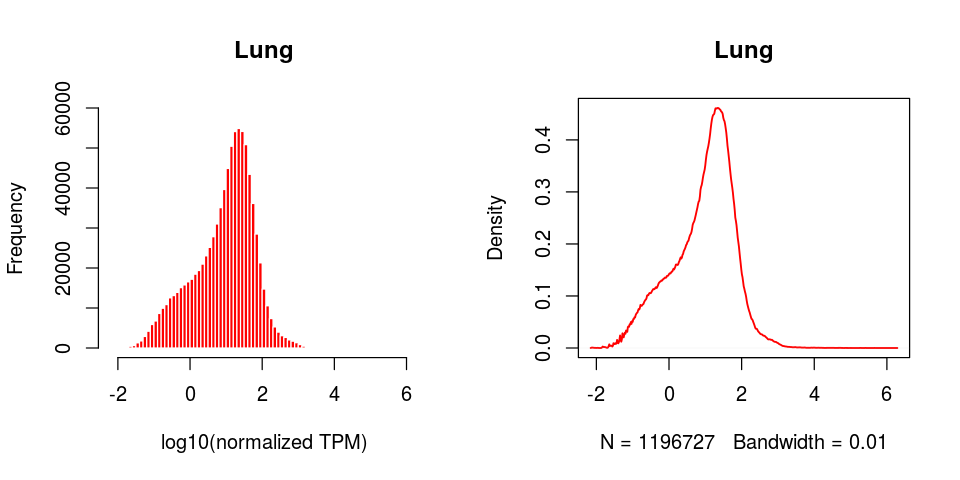

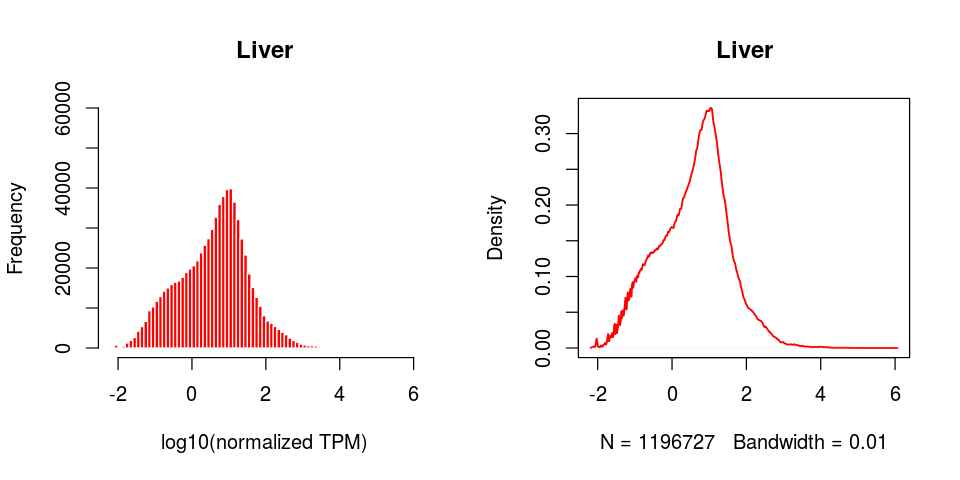

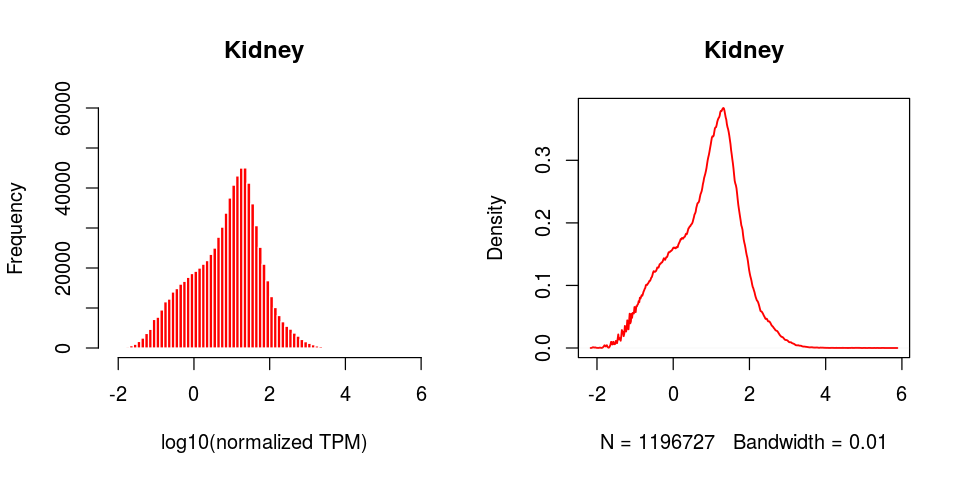

In [3]:
options(repr.plot.width=8, repr.plot.height=4)
par(mfrow=c(1,2))
hist(as.numeric(log10(lung.norm.cts)), breaks=100, border="white", col="red", ylim=c(0,60000),
     xlab="log10(normalized TPM)", main="Lung")
plot(density(as.numeric(log10(lung.norm.cts)), bw=0.01), main="Lung", col="red", lwd=1.5)

par(mfrow=c(1,2))
hist(as.numeric(log10(liver.norm.cts)), breaks=100, border="white", col="red", ylim=c(0,60000),
     xlab="log10(normalized TPM)", main="Liver")
plot(density(as.numeric(log10(liver.norm.cts)), bw=0.01), main="Liver", col="red", lwd=1.5)

par(mfrow=c(1,2))
hist(as.numeric(log10(kidney.norm.cts)), breaks=100, border="white", col="red", ylim=c(0,60000),
     xlab="log10(normalized TPM)", main="Kidney")
plot(density(as.numeric(log10(kidney.norm.cts)), bw=0.01), main="Kidney", col="red", lwd=1.5)


The histogram and density plots suggest that a normalized TPM of 1 would be a reasonable and conservative filtering threshold. As such we set a criterion of at least 5% of samples for a gene must have greater than 1 normalized TPM to be retained.

In [4]:
#Filter out lowly expressed genes
kidney.keep <- apply(kidney.norm.cts, 1, function(y){length(which(y>1))}) >= 0.05*ncol(kidney.norm.cts)
liver.keep <- apply(liver.norm.cts, 1, function(y){length(which(y>1))}) >= 0.05*ncol(liver.norm.cts)
lung.keep <- apply(lung.norm.cts, 1, function(y){length(which(y>1))}) >= 0.05*ncol(lung.norm.cts)
kidney.norm.cts <- t(kidney.norm.cts[kidney.keep,])
liver.norm.cts <- t(liver.norm.cts[liver.keep,])
lung.norm.cts <- t(lung.norm.cts[lung.keep,])


By this point the matrices of counts are almost in the correct form for use with the eQTL software. Once we have created the covariate matrices, we can convert everything into the final format. 

## Covariate matrix construction

The covariate matrices that we construct contain the following information for each sample:

* Sample ID - we use CC strain ID for this
* Sequencing center location
* Sequencing batch
* Haplotype dosages for every marker

In [5]:
#Load sequencing center labels
seq.center <- read.delim("../sequencing_center_info.txt", header=F)
seq.center <- cbind(seq.center, sapply(seq.center[,1], function(x){strsplit(as.character(x), split="_")[[1]][3]}))
colnames(seq.center) <- c("Sample","Center","ID")

#Load batch labels and add to partial covariate matrix
batch <- read.delim("../batch_info.txt", header=F)
batch.indices <- sapply(seq.center$Sample, function(x){which(batch[,1]==x)})
cov.data <- cbind(seq.center, batch[batch.indices,2])

#Load mouse ID to strain map
id.strain.map <- read.delim("../../id_strain_map.txt", header=T)
id.strain.map$ID <- as.numeric(id.strain.map$ID)
#Add strain labels to seq.center and reorder columns
sample.info <- cbind(cov.data, id.strain.map$Strain[sapply(seq.center$ID, function(x){which(id.strain.map$ID==x)})])
sample.info <- sample.info[,c(1,3,5,2,4)]
colnames(sample.info) <- c("Sample", "ID", "Strain", "Center","Batch")

#Load haplotype dosage matrix
dosages <- readRDS("../../genotype/20170331_covariate_matrix/results/dosage_covariate_matrix.rds")

#Create covariate matrices for each tissue
kidney.covdata <- sample.info[sapply(rownames(kidney.norm.cts), function(x){which(sample.info$Sample==x)}),][,c("Strain","Center","Batch")]
kidney.dosages <- dosages[sapply(kidney.covdata$Strain, function(x){which(rownames(dosages)==x)}),]
kidney.covdata <- cbind(kidney.covdata, kidney.dosages)
liver.covdata <- sample.info[sapply(rownames(liver.norm.cts), function(x){which(sample.info$Sample==x)}),][,c("Strain","Center","Batch")]
liver.dosages <- dosages[sapply(liver.covdata$Strain, function(x){which(rownames(dosages)==x)}),]
liver.covdata <- cbind(liver.covdata, liver.dosages)
lung.covdata <- sample.info[sapply(rownames(lung.norm.cts), function(x){which(sample.info$Sample==x)}),][,c("Strain","Center","Batch")]
lung.dosages <- dosages[sapply(lung.covdata$Strain, function(x){which(rownames(dosages)==x)}),]
lung.covdata <- cbind(lung.covdata, lung.dosages)

## Matrix reformatting and saving

With the expression matrices and covariate matrices in the right structure, we rename the strain column to "ID" as required by the eQTL software, rename the rows of the expression matrices to be strain names, and save the matrices to files.

In [6]:
colnames(kidney.covdata)[1] <- "ID"
colnames(liver.covdata)[1] <- "ID"
colnames(lung.covdata)[1] <- "ID"
rownames(kidney.norm.cts) <- sample.info[sapply(rownames(kidney.norm.cts), function(x){which(sample.info$Sample==x)}),][,"Strain"]
rownames(liver.norm.cts) <- sample.info[sapply(rownames(liver.norm.cts), function(x){which(sample.info$Sample==x)}),][,"Strain"]
rownames(lung.norm.cts) <- sample.info[sapply(rownames(lung.norm.cts), function(x){which(sample.info$Sample==x)}),][,"Strain"]

#Matrix size sanity check - each should be strain x gene/covariate
#Covariate matrices should be equal width
dim(kidney.norm.cts)
dim(liver.norm.cts)
dim(lung.norm.cts)
dim(kidney.covdata)
dim(liver.covdata)
dim(lung.covdata)

#Save matrices
saveRDS(object=kidney.norm.cts, file="results/expmat_control_kidney.rds")
saveRDS(object=liver.norm.cts, file="results/expmat_control_liver.rds")
saveRDS(object=lung.norm.cts, file="results/expmat_control_lung.rds")
saveRDS(object=kidney.covdata, file="results/covdata_control_kidney.rds")
saveRDS(object=liver.covdata, file="results/covdata_control_liver.rds")
saveRDS(object=lung.covdata, file="results/covdata_control_lung.rds")

[1]    49 15899

[1]    49 13633

[1]    49 17680

[1]     49 621779

[1]     49 621779

[1]     49 621779